# Import dependencies

In [1]:
import numpy as np
# from Scripts.DataManager.DabasePreparations.AmazonReviewSentiGraph import AmazonReviewSentiGraph
# from Scripts.Models.ModelsManager.SimpleGraphClassifierModelManager import SimpleGraphClassifierModelManager
from Scripts.Configs.ConfigClass import Config
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from lightning.pytorch.loggers import CSVLogger
import os
# os.environ['TORCH_USE_CUDA_DSA']
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = 'cuda'
batch_size = 128

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


# Load and prepare data

In [2]:
from typing import List, Set, Tuple, Any
from abc import ABC, abstractmethod

from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
# from torch_geometric.data.lightning.datamodule import LightningDataModule
from lightning.pytorch import LightningDataModule
from torch_geometric.utils import augmentation
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.utils import subgraph, train_test_split_edges
from torch_geometric.data import Data

from Scripts.Configs.ConfigClass import Config
from Scripts.Utils.GraphCollection.GraphCollection import GraphCollection


class GraphLoader(LightningDataModule):

    def __init__(self, config: Config, device, has_val: bool, has_test: bool, test_size=0.2, val_size=0.15, *args, **kwargs):
        super(GraphLoader, self).__init__() #has_val, has_test, **kwargs)
        self.config = config
        self.test_size = test_size
        self.val_size = val_size
        self.device = device

    @abstractmethod
    def prepare_data(self):
        pass

    @abstractmethod
    def setup(self, stage: str):
        pass

    @abstractmethod
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        pass

    @abstractmethod
    def test_dataloader(self) -> EVAL_DATALOADERS:
        pass

    @abstractmethod
    def val_dataloader(self) -> EVAL_DATALOADERS:
        pass

    @abstractmethod
    def teardown(self, stage: str) -> None:
        pass
    
    @abstractmethod
    def zero_rule_baseline():
        pass

    # def predict_dataloader(self) -> EVAL_DATALOADERS:
    # def transfer_batch_to_device(self, batch: Any, device: torch.device, dataloader_idx: int) -> Any:
    # def on_before_batch_transfer(self, batch: Any, dataloader_idx: int) -> Any:
    # def on_after_batch_transfer(self, batch: Any, dataloader_idx: int) -> Any:

In [3]:
from os import path
from typing import Dict

import pandas as pd
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader

from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.CoOccurrenceGraphConstructor import CoOccurrenceGraphConstructor
from Scripts.DataManager.GraphConstructor.GraphConstructor import GraphConstructor, TextGraphType
# from Scripts.DataManager.GraphLoader.GraphLoader import GraphLoader
from torch.utils.data.dataset import random_split
import torch
from Scripts.DataManager.Datasets.GraphConstructorDataset import GraphConstructorDataset

class AmazonReviewGraphLoader(GraphLoader):

    def __init__(self, config: Config, has_val: bool, has_test: bool, test_size=0.2, val_size=0.2, num_workers=2,
                 drop_last=True, train_data_path='', test_data_path='', graphs_path='', batch_size = 32,
                 device='cpu', shuffle = False, num_data_load=-1,
                 graph_type: TextGraphType = TextGraphType.CO_OCCURRENCE, *args, **kwargs):
        kwargs['num_workers'] = num_workers
        kwargs['batch_size'] = batch_size
        kwargs['num_workers'] = num_workers
        kwargs['shuffle'] = shuffle
        super(AmazonReviewGraphLoader, self)\
            .__init__(config, device, has_val, has_test, test_size, val_size, *args, **kwargs)

        self.device = device
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.drop_last = drop_last
        self.graph_type = graph_type
        self.train_data_path = 'data/Amazon-Review/train_sm.csv' if train_data_path == '' else train_data_path
        self.test_data_path = 'data/Amazon-Review/test_sm.csv' if test_data_path == '' else test_data_path
        self.train_df: pd.DataFrame = pd.DataFrame()
        self.test_df: pd.DataFrame = pd.DataFrame()
        self.labels = None
        self.dataset = None
        self.shuffle = shuffle
        self.num_node_features = 0
        self.num_classes = 0
        self.df: pd.DataFrame = pd.DataFrame()
        self.__train_dataset, self.__val_dataset, self.__test_dataset = None, None, None
        self.train_df = pd.read_csv(path.join(self.config.root, self.train_data_path))
        self.test_df = pd.read_csv(path.join(self.config.root, self.test_data_path))
        self.train_df.columns = ['Polarity', 'Title', 'Review']
        self.test_df.columns = ['Polarity', 'Title', 'Review']
        self.train_df = self.train_df[['Polarity', 'Review']]
        self.test_df = self.test_df[['Polarity', 'Review']]
        self.df = pd.concat([self.train_df, self.test_df])
        self.num_data_load = num_data_load if num_data_load>0 else self.df.shape[0]
        self.num_data_load = num_data_load if self.num_data_load < self.df.shape[0] else self.df.shape[0] 
        self.df = self.df.iloc[:self.num_data_load]
        self.df.index = np.arange(0, self.num_data_load)
        self.graph_constructors = self.__set_graph_constructors(self.graph_type)
        graph_constructor = self.graph_constructors[TextGraphType.CO_OCCURRENCE]
        graph_constructor.setup()
        print(f'self.num_data_load: {self.num_data_load}')
        labels = self.df['Polarity'][:self.num_data_load]
        labels = labels.apply(lambda p: 0 if p == 1 else 1).to_numpy()
        labels = torch.from_numpy(labels)
        self.labels = labels.to(torch.float32).view(-1, 1).to(self.device)
        graph_constructor = self.graph_constructors[TextGraphType.CO_OCCURRENCE]
        
        print(f'self.labels.shape: {self.labels.shape}')
        self.dataset = GraphConstructorDataset(graph_constructor, self.labels)
        sample_graph = graph_constructor.get_first()
        self.num_node_features = sample_graph.num_features
        self.num_classes = len(torch.unique(self.labels))
        self.__train_dataset, self.__val_dataset, self.__test_dataset =\
            random_split(self.dataset, [1-self.val_size-self.test_size, self.val_size, self.test_size])
        self.__train_dataloader =  DataLoader(self.__train_dataset, batch_size=self.batch_size, drop_last=self.drop_last, shuffle=self.shuffle, num_workers=self.num_workers, persistent_workers=True)
        self.__test_dataloader =  DataLoader(self.__test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
        self.__val_dataloader =  DataLoader(self.__val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
        
    def prepare_data(self):
        pass
        
    def setup(self, stage: str):
        pass

    def teardown(self, stage: str) -> None:
        pass

    def train_dataloader(self):
        return self.__train_dataloader

    def test_dataloader(self):
        return self.__test_dataloader

    def val_dataloader(self):
        return self.__val_dataloader 

    def __set_graph_constructors(self, graph_type: TextGraphType):
        graph_constructors: Dict[TextGraphType, GraphConstructor] = {}
        if TextGraphType.CO_OCCURRENCE in graph_type:
            graph_constructors[TextGraphType.CO_OCCURRENCE] = self.__get_co_occurrence_graph()
        if TextGraphType.DEPENDENCY in graph_type:
            pass
        if TextGraphType.SEQUENTIAL in graph_type:
            pass
        if TextGraphType.TAGS in graph_type:
            pass
        return graph_constructors

    def __get_co_occurrence_graph(self):
        print(f'self.num_data_load: {self.num_data_load}')
        return CoOccurrenceGraphConstructor(self.df['Review'][:self.num_data_load], 'data/GraphData/AmazonReview', self.config, lazy_construction=False, load_preprocessed_data=True, naming_prepend='graph', num_data_load=self.num_data_load, device=self.device)
    
    def zero_rule_baseline(self):
        return f'zero_rule baseline: {(len(self.labels[self.labels>0.5])* 100.0 / len(self.labels))  : .2f}%'


In [4]:
data_manager = AmazonReviewGraphLoader(config, True, True, num_workers=2, shuffle=True, num_data_load = -1, device='cpu', batch_size=batch_size)

self.num_data_load: 55000
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/AmazonReview\graph_var.txt
 0 graph loaded
 100 graph loaded
 200 graph loaded
 300 graph loaded
 400 graph loaded
 500 graph loaded
 600 graph loaded
 700 graph loaded
 800 graph loaded
 900 graph loaded
 1000 graph loaded
 1100 graph loaded
 1200 graph loaded
 1300 graph loaded
 1400 graph loaded
 1500 graph loaded
 1600 graph loaded
 1700 graph loaded
 1800 graph loaded
 1900 graph loaded
 2000 graph loaded
 2100 graph loaded
 2200 graph loaded
 2300 graph loaded
 2400 graph loaded
 2500 graph loaded
 2600 graph loaded
 2700 graph loaded
 2800 graph loaded
 2900 graph loaded
 3000 graph loaded
 3100 graph loaded
 3200 graph loaded
 3300 graph loaded
 3400 graph loaded
 3500 graph loaded
 3600 graph loaded
 3700 graph loaded
 3800 graph loaded
 3900 graph loaded
 4000 graph loaded
 4100 graph loaded
 4200 graph loaded
 4300 graph loaded
 4400 graph loaded
 4500 graph loaded
 4600 graph loade

# Train Data

In [5]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GATv2Conv, GCNConv, GCN2Conv, DenseGCNConv, dense_diff_pool, BatchNorm
from torch_geometric.nn import Sequential as GSequential
from torch_geometric.utils import to_dense_adj
from torch import nn

class GcnGatModel1(nn.Module):
    r"""
    This class is for graph level classification or graph level regression
    """

    def __init__(self, input_feature: int, out_features: int, base_hidden_feature: int=256, dropout=0.1, *args, **kwargs):
        super(GcnGatModel1, self).__init__(*args, **kwargs)
        self.input_features = input_feature
        self.num_out_features = out_features
        self.bsh: int = base_hidden_feature
        bsh2: int = int(self.bsh/2)
        bsh4: int = int(self.bsh/4)
        bsh8: int = int(self.bsh/8)
        
        self.encoder = GSequential('x, edge_index, edge_weights', [
            (GCNConv(input_feature, self.bsh), 'x, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            
            (GCNConv(self.bsh, bsh2), 'x1, edge_index, edge_weights -> x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            
            (GCNConv(bsh2, bsh4), 'x2, edge_index, edge_weights -> x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (nn.Dropout(dropout), 'x3->x3'),
            (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (nn.Dropout(dropout), 'x3->x3'),
            (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (nn.Dropout(dropout), 'x3->x3'),
            
            (GCNConv(bsh4, bsh8), 'x3, edge_index, edge_weights -> x4'),
            (BatchNorm(bsh8), 'x4->x4'),
            (nn.ReLU(), 'x4->x4'),
            (nn.Dropout(dropout), 'x4->x4'),
            (GCNConv(bsh8, bsh8), 'x4, edge_index, edge_weights -> x4'),
            (BatchNorm(bsh8), 'x4->x4'),
            (nn.ReLU(), 'x4->x4'),
            (nn.Dropout(dropout), 'x4->x4'),
            (GCNConv(bsh8, bsh8), 'x4, edge_index, edge_weights -> x4'),
            (BatchNorm(bsh8), 'x4->x4'),
            (nn.ReLU(), 'x4->x4'),
            (lambda x1, x2, x3, x4: (x1, x2, x3, x4), 'x1, x2, x3, x4 -> x1, x2, x3, x4')
        ])
        
        self.attention = GSequential('x3, x4, edge_index, edge_weights', [
            (GATv2Conv(bsh8, bsh8, 2, dropout=dropout), 'x4, edge_index ->x4'),
            (BatchNorm(bsh4), 'x4->x4'),
            (nn.ReLU(), 'x4->x4'),
            
            (GCN2Conv(bsh4, 0.5, 0.1, 2), 'x4, x3, edge_index, edge_weights->x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            
            (GATv2Conv(bsh4, bsh4, 2, dropout=dropout), 'x3, edge_index ->x3'),
            (BatchNorm(bsh2), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (lambda x3, x4: (x3, x4), 'x3, x4 -> x3, x4')
        ])
        
        self.decoder = GSequential('x1, x2, x3, edge_index, edge_weights', [
            
            (GCN2Conv(bsh2, 0.5, 0.1, 2), 'x3, x2, edge_index, edge_weights->x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            (GCNConv(bsh2, self.bsh), 'x2, edge_index->x2'),
            (BatchNorm(self.bsh), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            
            (GCN2Conv(self.bsh, 0.5, 0.1, 2), 'x2, x1, edge_index, edge_weights->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (lambda x1, x2, x3: (x1, x2, x3), 'x1, x2, x3 -> x, x2, x3')
        ])

        self.pooling_layer1 = GCNConv(self.bsh, 5)
        self.pooling_layer2 = DenseGCNConv(self.bsh, 1)
        self.output_layer = Linear(self.bsh, self.num_out_features)

    def forward(self, x):
        x1, x2, x3, x_enc = self.encoder(x.x, x.edge_index, x.edge_attr)
        x_att, x4 = self.attention(x3, x_enc, x.edge_index, x.edge_attr)
        x_dec, x2, x3 = self.decoder(x1, x2, x_att, x.edge_index, x.edge_attr)
        
        all_s = self.pooling_layer1(x_dec, x.edge_index, x.edge_attr)
        ci = torch.tensor([x[i].x.shape[0] for i in range(len(x))], dtype=torch.int, device=x_dec.device).cumsum(0, dtype=torch.int)
        x_list = [x_dec[0 if i == 0 else ci[i - 1]:ci[i]] for i in range(len(ci))]
        s_i = [all_s[0 if i == 0 else ci[i - 1]:ci[i]] for i in range(len(ci))]
        x_pooled = torch.zeros((len(x_list), self.bsh), dtype=x_dec.dtype, device=x_dec.device)
        
        for i in range(len(ci)):
            s = s_i[i]# self.pooling_layer1(x2[i], x[i].edge_index, x[i].edge_attr)
            adj = torch.zeros((x[i].x.shape[0], x[i].x.shape[0]), device=x_dec.device)
            adj[x[i].edge_index[0],x[i].edge_index[1]] = x[i].edge_attr
            # adj = to_dense_adj(edge_index=x[i].edge_index, max_num_nodes=x[i].x.shape[0], edge_attr=x[i].edge_attr)
            nodes, adj, _, _ = dense_diff_pool(x_list[i], adj, s=s)
            s = self.pooling_layer2(nodes, adj)
            nodes, _, _, _ = dense_diff_pool(nodes, adj, s=s)
            x_pooled[i] = torch.squeeze(nodes)

        # return x1
        return self.output_layer(x_pooled)

In [6]:
torch_model = GcnGatModel1(300, 1, 1024, dropout=0.2)
torch_model = torch_model.to(device)
next(iter(torch_model.parameters())).device

device(type='cuda', index=0)

In [7]:
t_dataloader = data_manager.train_dataloader()
v_dataloader = data_manager.val_dataloader()

In [8]:
X1, y1 = next(iter(t_dataloader))
X2, y2 = next(iter(v_dataloader))
print(X1[0].x.device)
print(X2[0].x.device)

cpu
cpu


In [9]:
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

torch.cuda.memory_allocated: 0.031685GB
torch.cuda.memory_reserved: 0.046875GB
torch.cuda.max_memory_reserved: 0.046875GB


In [10]:
next(iter(torch_model.parameters())).device

device(type='cuda', index=0)

In [11]:
import time
def train_model(target_model, num_epoch = 2, target_device='cpu'):
    target_model = target_model.to(target_device)
    loss_func = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(target_model.parameters(), 0.001, weight_decay=0.0055)
    for i in range(num_epoch):
        
        batch_acc=[]
        batch_loss = []
        begin = time.time()
        target_model.train()
        i = 0
        for X,y in t_dataloader:
            print(f'i: {i}')
            i = i + 1
            X = X.to(target_device)
            y = y.to(target_device)
            optimizer.zero_grad()
            predicted = target_model(X)
            loss = loss_func(predicted, y)
            loss.backward()
            optimizer.step()
            predicted = torch.nn.functional.sigmoid(predicted)
            predicted[predicted<0.5] = 0
            predicted[predicted>=0.5] = 1
            accuracy = torch.mean((predicted == y).to(torch.float32)).detach().item()
            batch_acc.append(accuracy)
            batch_loss.append(loss.item())
            torch.cuda.empty_cache()
        print(f'train accuracy: {np.mean(batch_acc)}, loss: {np.mean(batch_loss)}, duration: {time.time() - begin:0.4f}')
        
        target_model.eval()
        batch_acc=[]
        batch_loss = []
        i = 0
        for X,y in v_dataloader:
            print(f'i: {i}')
            i = i + 1
            X = X.to(target_device)
            y = y.to(target_device)
            with torch.inference_mode():
                predicted = target_model(X)
                loss = loss_func(predicted, y)
            predicted = torch.nn.functional.sigmoid(predicted)
            predicted[predicted<0.5] = 0
            predicted[predicted>=0.5] = 1
            accuracy = torch.mean((predicted == y).to(torch.float32)).detach().item()
            batch_acc.append(accuracy)
            batch_loss.append(loss.item())
            torch.cuda.empty_cache()
        print(f'validation accuracy: {np.mean(batch_acc)}, loss: {np.mean(batch_loss)}, duration: {time.time() - begin:0.4f}')

In [12]:
# train_model(torch_model, 5, 'cpu')

In [13]:
# train_model(torch_model, 5, 'cuda')

In [14]:
# for X, y in t_dataloader:
#     X = X.to('cuda')
#     # for i in range(len(X)):
#     #     X[i].x = X[i].x.to(device)
#     #     X[i].edge_index = X[i].edge_index.to(device)
#     #     X[i].edge_attr = X[i].edge_attr.to(device)
#     torch_model(X)
#     torch.cuda.empty_cache()

In [15]:
# from Scripts.Models.BaseModels.GcnGatModel1 import GcnGatModel1
from Scripts.Models.LightningModels.LightningModels import BinaryLightningModel
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import torch
import lightning as L
from lightning.pytorch.tuner import Tuner

In [16]:
callbacks = [
    ModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True),
    EarlyStopping(patience=50, mode='max', monitor='val_acc')
]

In [17]:
lightning_model = BinaryLightningModel(torch_model,
                                 torch.optim.Adam(torch_model.parameters(), lr=0.0001, weight_decay=0.00055),
                                       torch.nn.BCEWithLogitsLoss(),
                                       learning_rate=0.0001,
                                       batch_size=batch_size,
                                       ).to(device)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


device: cpu


In [18]:
print(next(iter(torch_model.parameters())).device)
print(lightning_model.device)

cuda:0
cuda:0


In [19]:
# torch_model(X)

In [20]:
# t_dataloader = data_manager.train_dataloader()
# loss_func = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(torch_model.parameters(), 0.001, weight_decay=0.0055)
# for X,y in t_dataloader:
#     optimizer.zero_grad()
#     predicted = torch_model(X)
#     loss = loss_func(predicted, y)
#     loss.backward()
#     optimizer.step()

In [21]:
trainer = L.Trainer(
            callbacks=callbacks,
            max_epochs=1000,
            accelerator='gpu',
            logger=CSVLogger(save_dir='logs/', name='GcnGatSentiment2'),
            num_sanity_val_steps=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
# tuner = Tuner(trainer)
# results = tuner.lr_find(lightning_model, datamodule=data_manager, min_lr=0.00001,max_lr=0.03)

In [23]:
# fig = results.plot(suggest=True)

In [24]:
# 0.00004

In [25]:
lightning_model.device

device(type='cuda', index=0)

In [26]:

# trainer.fit(lightning_model, datamodule=data_manager)
trainer.fit(lightning_model,
            datamodule=data_manager
            # train_dataloaders=data_manager.train_dataloader(),
            # val_dataloaders=data_manager.val_dataloader(),
            # logger=CSVLogger(save_dir='logs/', name='sample_model'),
            # default_root_dir="~/Desktop"
            )

model1: <class 'Scripts.Models.LightningModels.LightningModels.BinaryLightningModel'>


You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | GcnGatModel1      | 8.5 M 
1 | loss_func | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
4 | test_acc  | BinaryAccuracy    | 0     
------------------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params
33.911    Total estimated model params size (MB)


bbbb
model2: <class 'Scripts.Models.LightningModels.LightningModels.BinaryLightningModel'>
arg: <class 'Scripts.Models.LightningModels.LightningModels.BinaryLightningModel'>
arg: <class 'NoneType'>
arg: <class 'NoneType'>
arg: <class '__main__.AmazonReviewGraphLoader'>
arg: <class 'NoneType'>
kwargs: {}
trainer_fn1: <bound method Trainer._fit_impl of <lightning.pytorch.trainer.trainer.Trainer object at 0x000001C30C53B880>>
trainer_fn2: <class 'method'>


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:59: Detected KeyboardInterrupt, attempting graceful shutdown...


In [33]:
import matplotlib.pyplot as plt
'''From torch lightning tutorials'''
def plot_csv_logger(csv_path, loss_names=['training_loss', 'val_loss'], eval_names=['training_acc', 'val_acc']):
    metrics = pd.read_csv(csv_path)
    
    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)
    
    df_metrics = pd.DataFrame(aggregation_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
    plt.show()
    

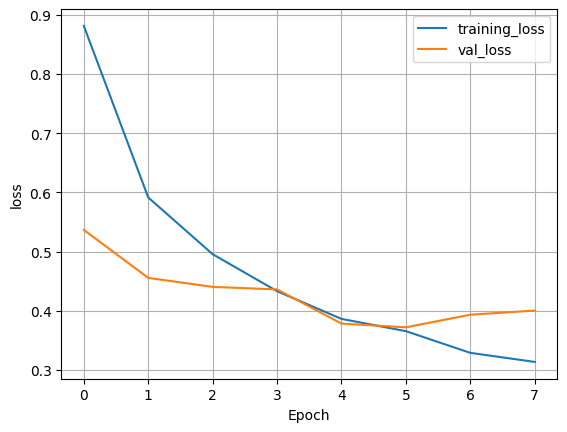

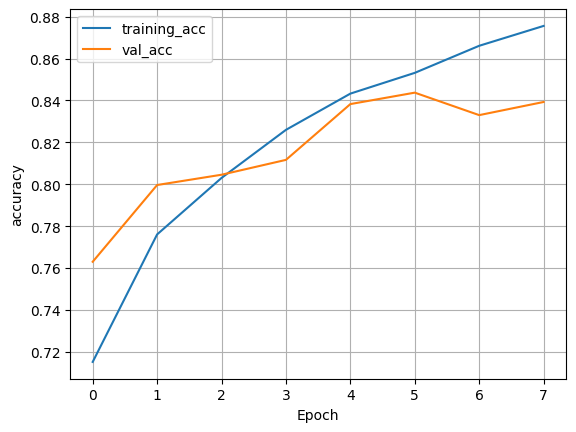

In [34]:
plot_csv_logger(r'C:\Users\fardin\Projects\ColorIntelligence\logs\GcnGatSentiment2\version_1\metrics.csv')

In [28]:
trainer.checkpoint_callback.best_model_path

'logs/GcnGatSentiment2\\version_1\\checkpoints\\epoch=5-step=1542.ckpt'

In [ ]:
# trainer.save_checkpoint('example.ckpt')
BinaryLightningModel.load_from_checkpoint(checkpoint_path='example.ckpt', model=torch_model)

NameError: name 'BinaryLightningModel' is not defined

In [ ]:
lightning_model.eval()
with torch.inference_mode():
    logits = lightning_model('new_data')

AttributeError: 'str' object has no attribute 'x'

In [ ]:
trainer.test(model=lightning_model, datamodule=data_manager, ckpt_path='best')

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import summary
from tqdm import tqdm
from Scripts.Models.LightningModels.LightningModels import BaseLightningModel
from Scripts.Models.ModelsManager.ModelManager import ModelManager
from Scripts.Models.BaseModels.GATGCNClassifierSimple import GNNClassifier
from Scripts.DataManager.GraphLoader.NLabeledGraphLoader import NLabeledGraphLoader
from Scripts.Utils.enums import Optimizer, LossType

import lightning as L


class SimpleNodeClassifierModelManager(ModelManager):

    def __init__(self, graph_handler: NLabeledGraphLoader, device=torch.device('cpu'),
                 lr=0.01, weight_decay=0.001, optimizer_type: Optimizer = Optimizer.ADAM,
                 loss_type: LossType = LossType.CROSS_ENTROPY):
        super(SimpleNodeClassifierModelManager, self).__init__(lr, weight_decay, device)
        self.graph_handler = graph_handler
        self.num_output_classes = self.graph_handler.num_classes
        self.num_input_features = self.graph_handler.num_features
        self.loss_type = loss_type
        self.optimizer_type = optimizer_type
        self.model, self.optimizer, self.loss_func = self._create_model(lr, weight_decay, optimizer_type, loss_type)
        self.lightning_model = BaseLightningModel(self.model, self.optimizer, self.loss_func)

    def train(self, epoch_num: int = 100, lr: float = None, l2_norm: float = None, optimizer: Optimizer = None):

        trainer = L.Trainer(max_epochs=100, accelerator='gpu', devices=1)
        trainer.fit(self.lightning_model,
                    train_dataloaders=self.graph_handler.get_train_data(),
                    val_dataloaders=self.graph_handler.get_val_data()
                    )



        if lr or l2_norm or optimizer:
            self.set_optimizer(lr, l2_norm, optimizer)

        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []

        train_node_x, train_node_y, train_edges = self.graph_handler.get_train_data()
        test_node_x, test_node_y, test_edges = self.graph_handler.get_test_data()
        for i in tqdm(range(epoch_num)):
            self.model.train()
            self.optimizer.zero_grad()
            my_node, my_label, my_edges = self.graph_handler.extract_random_sub_edges_graph()
            y_hat: torch.Tensor = self.model(my_node, my_edges)
            loss = self.loss_func(F.one_hot(my_label, self.num_output_classes).float(), y_hat)
            loss.backward()
            self.optimizer.step()

            self.model.eval()

            loss_value = loss.item()
            train_losses.append(loss_value)
            accuracy = (torch.sum((y_hat.argmax(dim=1) == my_label).float()) / len(my_label)).cpu().numpy()
            train_accuracies.append(accuracy)

            my_node, my_label, my_edges = self.graph_handler.extract_random_sub_edges_graph()
            y_hat: torch.Tensor = self.model(my_node, my_edges)
            loss = self.loss_func(F.one_hot(my_label, self.graph_handler.num_classes).float(), y_hat)
            loss_value = loss.item()
            test_losses.append(loss_value)
            accuracy = (torch.sum((y_hat.argmax(dim=1) == my_label).float()) / len(my_label)).cpu().numpy()
            test_accuracies.append(accuracy)
        self.history['train_losses'] = train_losses
        self.history['train_accuracies'] = train_accuracies
        self.history['test_losses'] = test_losses
        self.history['test_accuracies'] = test_accuracies
        return self.history

    def evaluate(self):
        node_x, node_y, edges = self.graph_handler.get_val_data()
        self.model.eval()
        y_hat: torch.Tensor = self.model(node_x, edges)
        loss = self.loss_func(F.one_hot(node_y, self.num_output_classes).float(), y_hat)
        return y_hat, loss

    def predict(self, node_x, edge_index):
        self.model.eval()
        y_hat: torch.Tensor = self.model(node_x, edge_index)
        return y_hat

    def draw_summary(self):
        nodes_x, nodes_y, edge_indices_test = self.graph_handler.get_test_data()
        nodes_x, nodes_y, edge_indices_test = self.graph_handler.extract_random_sub_edges_graph(2)
        print(summary(self.model, nodes_x, edge_indices_test))

    def _create_model(self, lr, l2_norm, optimizer_type, loss_type):
        model = GNNClassifier(input_feature=self.num_input_features, class_counts=self.num_output_classes)
        optimizer = ModelManager._create_optimizer(model, lr, l2_norm, optimizer_type)
        loss_func = ModelManager._create_loss_func(loss_type)
        model.to(self.device)
        return model, optimizer, loss_func

    def set_optimizer(self, lr, l2_norm, optimizer=Optimizer.ADAM):
        if lr:
            self.lr = lr
        if l2_norm:
            self.l2_norm = l2_norm
        if optimizer:
            self.optimizer_type = optimizer
        self.optimizer = ModelManager._create_optimizer(self.model, self.lr, self.l2_norm, self.optimizer_type)


In [ ]:
# from Scripts.Models.ModelsManager.SimpleGraphClassifierModelManager import SimpleGraphClassifierModelManager

if 'Train Data':
    model_manager = SimpleGraphClassifierModelManager(
        data_manager.graph_constructors[TextGraphType.CO_OCCURRENCE])
    model_manager.draw_summary()
    model_manager.train()
    model_manager.draw_training_results()

# Draw Results

In [ ]:
from Scripts.Models.BaseModels.GcnGatModel1 import GcnGatModel1
from transformers.models.longformer.convert_longformer_original_pytorch_lightning_to_pytorch import LightningModel
mymodel = GcnGatModel1(100, 10, config)
print(type(mymodel))
model = LightningModel(mymodel)
print(type(model))

In [ ]:
from typing import Tuple


def sample_func() -> Tuple[int, float]:
    return 1, 2.5

In [ ]:
targets = sample_func

In [ ]:
type(targets)

In [ ]:
from Scripts.Utils.enums import Optimizer

type(Optimizer.ADAM)

In [ ]:
def sample_func():
    return True

In [ ]:
from typing import Callable
import types

In [ ]:
aa: Callable = None
type(aa)